# 5G NR PUSCH Tutorial

This notebook provides an introduction to Sionna's [5G New Radio (NR) module](https://nvlabs.github.io/sionna/api/nr.html) and, in particular, the [physical uplink shared channel (PUSCH)](https://nvlabs.github.io/sionna/api/nr.html#pusch). This module provides implementations of a small subset of the physical layer functionalities as described in the 3GPP specifications [38.211](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3213), [38.212](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3214) and [38.214](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3216). 


You will

- Get an understanding of the different components of a PUSCH configuration, such as the carrier, DMRS, and transport block,
- Learn how to rapidly simulate PUSCH transmissions for multiple transmitters,
- Modify the PUSCHReceiver to use a custom MIMO Detector.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [A "Hello World!" Example](#A-Hello-World-Example)
* [Carrier Configuration](#Carrier-Configuration)
* [Understanding the DMRS Configuration](#Understanding-the-DMRS-Configuration)
    * [Configuring Multiple Layers](#Configuring-Multiple-Layers)
    * [Controlling the Number of DMRS Symbols in a Slot](#Controlling-the-Number-of-DMRS-Symbols-in-a-Slot)
    * [How to control the number of available DMRS ports?](#How-to-control-the-number-of-available-DMRS-ports?)
* [Transport Blocks and MCS](#Transport-Blocks-and-MCS)
* [Looking into the PUSCHTransmitter](#Looking-into-the-PUSCHTransmitter)
* [Components of the PUSCHReceiver](#Components-of-the-PUSCHReceiver)
* [End-to-end PUSCH Simulations](#End-to-end-PUSCH-Simulations)


## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# tahtan
# Import Sionna
import sys
sys.path.append('../')
import sionna

# try:
#     import sionna
# except ImportError as e:
#     # Install Sionna if package is not already installed
#     import os
#     os.system("pip install sionna")
#     import sionna

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible results

# Load the required Sionna components
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver, CarrierConfig, PUSCHDMRSConfig,\
                        TBConfig, PUSCHPilotPattern, TBEncoder, PUSCHPrecoder, LayerMapper, LayerDemapper, check_pusch_configs,\
                        TBDecoder, PUSCHLSChannelEstimator
from sionna.nr.utils import generate_prng_seq
from sionna.channel import AWGN, RayleighBlockFading, OFDMChannel, TimeChannel, time_lag_discrete_time_channel
from sionna.channel.utils import * 
from sionna.channel.tr38901 import Antenna, AntennaArray, UMi, UMa, RMa, TDL, CDL
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.utils import compute_ber, ebnodb2no, sim_ber, array_to_hash, create_timestamped_folders, b2b, f2f, BinarySource
from sionna.ofdm import KBestDetector, LinearDetector, MaximumLikelihoodDetector,\
        LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper,\
        ResourceGrid, ResourceGridMapper, OFDMModulator
from sionna.mimo import StreamManagement
from sionna.mapping import Mapper, Demapper


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
# from bs4 import BeautifulSoup
import pickle
from collections import namedtuple
import json
from tqdm.notebook import tqdm
import itertools
import io

## A Hello World Example

Let us start with a simple "Hello, World!" example in which we will simulate PUSCH transmissions from a single transmitter to a single receiver over an AWGN channel.

In [3]:
_num_tx = 1
_num_rx = 1
_num_tx_ant = 1
_num_rx_ant = 8
_carrier_frequency = 2.55e9  # Carrier frequency in Hz.
_link_direction = "uplink"

In [11]:
class MyPUSCHConfig(PUSCHConfig):
    def __init__(self):
        super().__init__(
            carrier_config=CarrierConfig(
                n_cell_id=0,
                cyclic_prefix="normal",
                subcarrier_spacing=30,
                n_size_grid=273,
                n_start_grid=0,
                slot_number=4,
                frame_number=0
            ),
            pusch_dmrs_config=PUSCHDMRSConfig(
                config_type=1,
                length=1,
                additional_position=1,
                dmrs_port_set=[0],
                n_id=0,
                n_scid=0,
                num_cdm_groups_without_data=2,
                type_a_position=2
            ),
            tb_config=TBConfig(
                channel_type='PUSCH',
                n_id=0,
                mcs_table=1,
                mcs_index=9
            ),
            mapping_type='A',
            n_size_bwp=273,
            n_start_bwp=0,
            num_layers=1,
            num_antenna_ports=1,
            precoding='non-codebook',
            tpmi=0,
            transform_precoding=False,
            n_rnti=2008,
            symbol_allocation=[0,14]
        )

_pusch_config_0 = MyPUSCHConfig()

In [5]:
df = pd.read_parquet('/workspaces/thanh/Dataset/tmp/parquet/20250218100553687974.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nSFN                      40 non-null     int64  
 1   nSlot                     40 non-null     int64  
 2   nPDU                      40 non-null     int64  
 3   nGroup                    40 non-null     int64  
 4   nUlsch                    40 non-null     int64  
 5   nUlcch                    40 non-null     int64  
 6   nRachPresent              40 non-null     int64  
 7   nRNTI                     40 non-null     int64  
 8   nUEId                     40 non-null     int64  
 9   nBWPSize                  40 non-null     int64  
 10  nBWPStart                 40 non-null     int64  
 11  nSubcSpacing              40 non-null     int64  
 12  nCpType                   40 non-null     int64  
 13  nULType                   40 non-null     int64  
 14  nMcsTable   

In [28]:
pickles_dir = '../Dataset/tmp/pickle'
parquet_path = '../Dataset/tmp/parquet/20250219023946984647.parquet'

df = pd.read_parquet(parquet_path, engine="pyarrow")

In [29]:
df.nMCS.unique()

array([3])

In [60]:
df

,nSFN,nSlot,nPDU,nGroup,nUlsch,nUlcch,nRachPresent,nRNTI,nUEId,nBWPSize,...,nTPPuschID,nRxRUIdx,nUE,nPduIdx,Channel_model,Speed,Delay_spread,Esno_db,Data_filename,Data_dirname
0,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,-15.0,20250219023948294263,20250219023946984647
1,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,-15.0,20250219023949032097,20250219023946984647
2,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,-15.0,20250219023949715570,20250219023946984647
3,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,-15.0,20250219023950369120,20250219023946984647
4,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,-14.0,20250219023951143932,20250219023946984647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,13.0,20250219024110635165,20250219023946984647
116,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,14.0,20250219024111264607,20250219023946984647
117,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,14.0,20250219024112465293,20250219023946984647
118,0,4,1,1,1,0,0,2008,0,273,...,0,"[0, 1, 2, 3, 4, 5, 6, 7]",1,[0],CDL-A,10,1.500000e-07,14.0,20250219024113194288,20250219023946984647


In [30]:
mcs_params = {
    'tb_size': [],
    'num_coded_bits': [],
    'target_coderate': [],
    'num_bits_per_symbol': []
}
for mcs in range(0,10):
    pusch_config_i = _pusch_config_0.clone()
    pusch_config_i.tb.mcs_index = mcs
    mcs_params['tb_size'].append(pusch_config_i.tb_size)
    mcs_params['num_coded_bits'].append(pusch_config_i.num_coded_bits)
    mcs_params['target_coderate'].append(pusch_config_i.tb.target_coderate)
    mcs_params['num_bits_per_symbol'].append(pusch_config_i.tb.num_bits_per_symbol)

mcs_params

{'tb_size': [9216,
  12040,
  14856,
  19464,
  23568,
  29192,
  34816,
  39936,
  46104,
  52224],
 'num_coded_bits': [78624,
  78624,
  78624,
  78624,
  78624,
  78624,
  78624,
  78624,
  78624,
  78624],
 'target_coderate': [0.1171875,
  0.1533203125,
  0.1884765625,
  0.2451171875,
  0.30078125,
  0.3701171875,
  0.4384765625,
  0.513671875,
  0.587890625,
  0.6630859375],
 'num_bits_per_symbol': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}

In [31]:
slot_params = {
    'pilots': []
}
pusch_slots_in_frame = [4,5,14,15]
num_pusch_slots_in_frame = len(pusch_slots_in_frame)
for slot_index in pusch_slots_in_frame:
    pusch_config_i = _pusch_config_0.clone()
    pusch_config_i.carrier.slot_number = slot_index
    pilot_pattern_i = PUSCHPilotPattern([pusch_config_i], dtype=tf.complex64)
    slot_params['pilots'].append(pilot_pattern_i.pilots)

slot_params

{'pilots': [<tf.Variable 'Variable:0' shape=(1, 1, 6552) dtype=complex64, numpy=
  array([[[-1.-1.j,  0.+0.j, -1.-1.j, ...,  0.+0.j,  1.-1.j,  0.+0.j]]],
        dtype=complex64)>,
  <tf.Variable 'Variable:0' shape=(1, 1, 6552) dtype=complex64, numpy=
  array([[[ 1.+1.j,  0.+0.j,  1.-1.j, ...,  0.+0.j, -1.-1.j,  0.+0.j]]],
        dtype=complex64)>,
  <tf.Variable 'Variable:0' shape=(1, 1, 6552) dtype=complex64, numpy=
  array([[[ 1.+1.j,  0.+0.j, -1.+1.j, ...,  0.+0.j, -1.-1.j,  0.+0.j]]],
        dtype=complex64)>,
  <tf.Variable 'Variable:0' shape=(1, 1, 6552) dtype=complex64, numpy=
  array([[[ 1.-1.j,  0.+0.j, -1.+1.j, ...,  0.+0.j,  1.+1.j,  0.+0.j]]],
        dtype=complex64)>]}

In [32]:
def load_pickle(filename):
    """Saves data to a pickle file."""
    with open(filename, "rb") as f:
        return pickle.load(f)

def data_loader(df, pickes_dir, direct=False):
    #  # .sample(frac=1) for shuffing
    for pusch_record in df.sample(frac=1).itertuples():
        data_filename = pusch_record.Data_filename
        data_dirname = pusch_record.Data_dirname
        esno_db = pusch_record.Esno_db
        index = pusch_record.Index
        # 1 tx
        if not direct:
            b = load_pickle(f'{pickes_dir}/{data_dirname}/{data_filename}.b.pkl')[0]
            c = load_pickle(f'{pickes_dir}/{data_dirname}/{data_filename}.c.pkl')[0]
            y = load_pickle(f'{pickes_dir}/{data_dirname}/{data_filename}.y.pkl')[0]
        else:
            b = load_pickle(f'{pickes_dir}/{data_filename}.b.pkl')[0]
            c = load_pickle(f'{pickes_dir}/{data_filename}.c.pkl')[0]
            y = load_pickle(f'{pickes_dir}/{data_filename}.y.pkl')[0]

        c_len = tf.shape(c)[-1]
        b_len = tf.shape(b)[-1]

        b = tf.pad(b, [[0,0],[0,c_len-b_len]])  # Pad b with zeros to match c
        # b_mask = tf.concat([tf.ones(b_len, dtype=tf.uint8), tf.zeros(c_len - b_len, dtype=tf.uint8)], axis=-1)

        yield esno_db, c, y, b, b_len

def preprocessing(esno_db, c, y, b, b_len):
    c = c[0]
    y = y[0]
    b = b[0]

    No = 10**(-esno_db / 10.)

    c = tf.transpose(tf.reshape(c, [12,-1,2]), perm=[2,0,1])

    y = tf.concat([y[...,0:2,410:-410],y[...,3:11,410:-410], y[...,12:14,410:-410]],axis=-2)
    y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)

    return No, c, y, b, b_len

def preprocessing_2(esno_db, c, y, b, b_len):
    No, c, y, b, b_len = preprocessing(esno_db, c, y, b, b_len)
    # c: (2, 12, 3276)
    # y: (16, 12, 3276)
    c = tf.transpose(tf.reshape(c, [2,12, -1, 12]), perm=[2,0,1,3])
    y = tf.transpose(tf.reshape(y, [16,12, -1, 12]), perm=[2,0,1,3])
    return No, c, y, b, b_len


# df = df[(df['nMCS'] == 9) & (df['nSlot'] == 4)] 

dataset = tf.data.Dataset.from_generator(
            lambda: data_loader(df, pickles_dir, False),
            # (ebno_db, c, y, b, b_len)
            output_types=(tf.float32, tf.float32, tf.complex64, tf.float32, tf.int32))

for n, (esno_db, c, y, b, b_len) in enumerate(dataset.batch(32)):
    print(n, esno_db.shape, c.shape, y.shape, b.shape, b_len.shape)
    if n == 2: break
for n, (esno_db, c, y, b, b_len) in enumerate(dataset.map(preprocessing).batch(32)):
    print(n, esno_db.shape, c.shape, y.shape, b.shape, b_len.shape)
    if n == 2: break
for n, (esno_db, c, y, b, b_len) in enumerate(dataset.map(preprocessing_2).batch(32)):
    print(n, esno_db.shape, c.shape, y.shape, b.shape, b_len.shape)
    if n == 2: break

0 (32,) (32, 1, 78624) (32, 1, 8, 14, 4096) (32, 1, 78624) (32,)
1 (32,) (32, 1, 78624) (32, 1, 8, 14, 4096) (32, 1, 78624) (32,)
2 (32,) (32, 1, 78624) (32, 1, 8, 14, 4096) (32, 1, 78624) (32,)
0 (32,) (32, 2, 12, 3276) (32, 8, 24, 3276) (32, 78624) (32,)
1 (32,) (32, 2, 12, 3276) (32, 8, 24, 3276) (32, 78624) (32,)
2 (32,) (32, 2, 12, 3276) (32, 8, 24, 3276) (32, 78624) (32,)
0 (32,) (32, 273, 2, 12, 12) (32, 273, 16, 12, 12) (32, 78624) (32,)
1 (32,) (32, 273, 2, 12, 12) (32, 273, 16, 12, 12) (32, 78624) (32,)
2 (32,) (32, 273, 2, 12, 12) (32, 273, 16, 12, 12) (32, 78624) (32,)


In [33]:
_pusch_config_0 = MyPUSCHConfig()
_pusch_config_0.tb.mcs_index = 3
_pusch_config_0.carrier.slot_number = 4

_tb_size = _pusch_config_0.tb_size
_num_coded_bits = _pusch_config_0.num_coded_bits
_target_coderate = _pusch_config_0.tb.target_coderate
_num_bits_per_symbol = _pusch_config_0.tb.num_bits_per_symbol
_num_layers = _pusch_config_0.num_layers
_n_rnti = _pusch_config_0.n_rnti
_n_id = _pusch_config_0.tb.n_id

_tb_encoder = TBEncoder(
                target_tb_size=_tb_size,
                num_coded_bits=_num_coded_bits,
                target_coderate=_target_coderate,
                num_bits_per_symbol=_num_bits_per_symbol,
                num_layers=_num_layers,
                n_rnti=_n_rnti,
                n_id=_n_id,
                channel_type="PUSCH", # PUSCHTransmitter
                codeword_index=0, # not supported for PUSCH
                use_scrambler=True,
                verbose=False,
                output_dtype=tf.float32)

_layer_mapper = LayerMapper(num_layers=_num_layers, dtype=tf.complex64)

_dmrs_length = _pusch_config_0.dmrs.length
_dmrs_additional_position = _pusch_config_0.dmrs.additional_position
_num_cdm_groups_without_data = _pusch_config_0.dmrs.num_cdm_groups_without_data
_n_scid = _pusch_config_0.dmrs.n_scid
_n_id_n_scid = _pusch_config_0.dmrs.n_id[0]



_pilot_pattern = PUSCHPilotPattern([_pusch_config_0],
                                        dtype=tf.complex64)
_mu = 1
_num_ofdm_symbols = 14
_fft_size = 4096
_cyclic_prefix_length = 288
_subcarrier_spacing = 30e3
_num_guard_subcarriers = (410, 410)
_num_slots_per_frame = 20

# Define the resource grid.
_resource_grid = ResourceGrid(
    num_ofdm_symbols=_num_ofdm_symbols,
    fft_size=_fft_size,
    subcarrier_spacing=_subcarrier_spacing,
    num_tx=1,
    num_streams_per_tx=1,
    cyclic_prefix_length=_cyclic_prefix_length,
    num_guard_carriers=_num_guard_subcarriers,
    dc_null=False,
    pilot_pattern=_pilot_pattern,
    dtype=tf.complex64
)

_channel_estimator = PUSCHLSChannelEstimator(
                _resource_grid,
                _dmrs_length,
                _dmrs_additional_position,
                _num_cdm_groups_without_data,
                interpolation_type='lin',
                dtype=tf.complex64)

_rx_tx_association = np.ones([_num_rx, _num_tx], bool)
_stream_management = StreamManagement(_rx_tx_association, _num_layers)
_mimo_detector = LinearDetector("lmmse", "bit", "maxlog", _resource_grid,
                                _stream_management, "qam", _num_bits_per_symbol, dtype=tf.complex64)
_layer_demapper = LayerDemapper(_layer_mapper, num_bits_per_symbol=_num_bits_per_symbol)
_tb_decoder = TBDecoder(_tb_encoder, output_dtype=tf.float32)
            

In [56]:
# batch test for records have the same pusch_config_0
df_mcs_slot = df[(df['nMCS'] == 3) & (df['nSlot'] == 4) & (df['Esno_db'] < 1000)]
# _channel_estimator._pilot_pattern.pilots = slot_params['pilots'][2]
dataset = tf.data.Dataset.from_generator(
            lambda: data_loader(df_mcs_slot, pickles_dir),
            output_types=(tf.float32, tf.float32, tf.complex64, tf.float32, tf.int32))
rates = []
bers = []
for n, (esno_db, c, y, b, b_len) in enumerate(tqdm(dataset.batch(1), total=len(df_mcs_slot))):
    h_hat,err_var = _channel_estimator([y, 10**(-esno_db/10.)])
    llr_ = _mimo_detector([y, h_hat, err_var, 10**(-esno_db/10.)])
    llr = _layer_demapper(llr_)

    bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
    bce = tf.reduce_mean(bce)
    rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)

    rates.append(rate)
    
    print(rate)
    # break
    b_hat, tb_crc_status = _tb_decoder(llr)
    # print(compute_ber(b[:,:,:b_len[0]], b_hat))

    ber = compute_ber(b[:,:,:b_len[0]], b_hat)
    print(ber)
    bers.append(ber)


  0%|          | 0/120 [00:00<?, ?it/s]

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.1656254, shape=(), dtype=float32)
tf.Tensor(0.1758117550349363, shape=(), dtype=float64)
tf.Tensor(0.9994361, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9989468, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.46830976, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.99830514, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9985429, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9964278, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9916958, shape=(), dtype=float32)
tf.Tensor(0.0, 

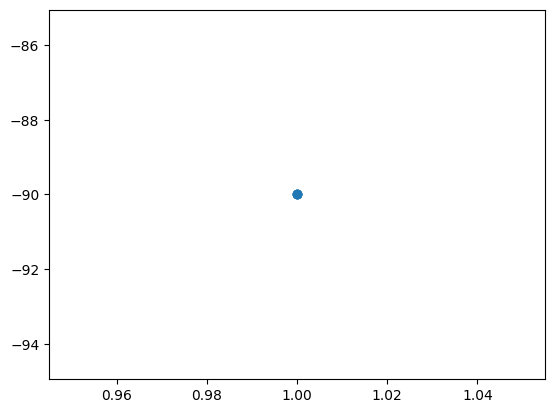

In [52]:
plt.scatter(rates, 10*np.log10(np.array(bers)+1e-9))

In [54]:
bers1

[<tf.Tensor: shape=(), dtype=float64, numpy=0.5021064529387588>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49845869297163997>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4994862309905467>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.500308261405672>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4945540484997945>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4966091245376079>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49974311549527334>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5016954377311961>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5042642827784628>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49856144677353065>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.500924784217016>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49702013974517056>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49845869297163997>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5021064529387588>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5038018906699548>,
 <tf.Tensor: shape=(),

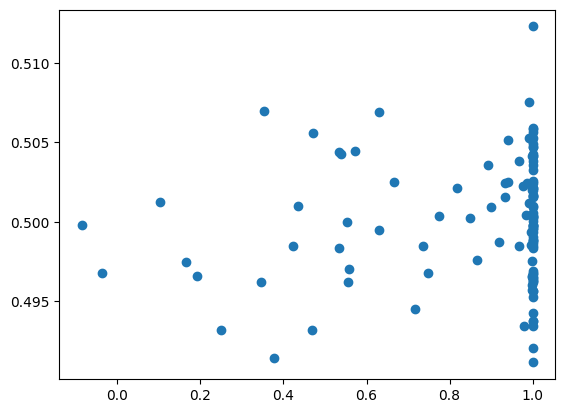

In [53]:
plt.scatter(rates1, bers1)

Hopefully you have enjoyed this tutorial on Sionna's 5G NR PUSCH module!

Please have a look at the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) of the various components or the other available [tutorials](https://nvlabs.github.io/sionna/tutorials.html) to learn more.